In [354]:
%load_ext autoreload
%autoreload 2
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from source.read_open_dataset import DatasetOpenDataset, openDatasetParticipants
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL

FEATURE_SIZE = 16
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
CLASS_LABELS = ['Sedentary', 'Light']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Reading the dataset

In [355]:
# dataset = DatasetHARUML20(mode='leave-one-subject')
dataset = DatasetPAMAP2(mode='leave-one-subject')

dataset.loadData()

dataset.Int_train[dataset.Int_train==2] = 1
dataset.Int_train[dataset.Int_train==3] = 1

dataset.Int_test[dataset.Int_test==2] = 1
dataset.Int_test[dataset.Int_test==3] = 1

# dataset.Int_train[dataset.Int_train==1] = 4
# dataset.Int_train[dataset.Int_train==0] = 1
# dataset.Int_train[dataset.Int_train==2] = 1
# dataset.Int_train[dataset.Int_train==3] = 1
# dataset.Int_train[dataset.Int_train==4] = 0

# dataset.Int_test[dataset.Int_test==1] = 4
# dataset.Int_test[dataset.Int_test==0] = 1
# dataset.Int_test[dataset.Int_test==2] = 1
# dataset.Int_test[dataset.Int_test==3] = 1
# dataset.Int_test[dataset.Int_test==4] = 0



# dataset.Int_train[dataset.Int_train==1] = 0
# dataset.Int_train[dataset.Int_train==2] = 0
# dataset.Int_train[dataset.Int_train==3] = 1

# dataset.Int_test[dataset.Int_test==1] = 0
# dataset.Int_test[dataset.Int_test==2] = 0
# dataset.Int_test[dataset.Int_test==3] = 1

In [356]:
print('Unique Labels (intensities): {}'.format(np.unique(dataset.Int_train)))
print('Signals: {}'.format(dataset.signals))
print('Sedentary windows: {}  Light windows: {}'.format(len(dataset.Int_train[dataset.Int_train == 0]), len(dataset.Int_train[dataset.Int_train == 1])))

Unique Labels (intensities): [0. 1.]
Signals: ['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1', 'handMagne2', 'handMagne3']
Sedentary windows: 2295  Light windows: 3879


# Data preparation

In [357]:
# Preparing data
ts_train = TSerie(dataset.X_train[:,:,:3], dataset.Int_train)
ts_test = TSerie(dataset.X_test[:,:,:3], dataset.Int_test)

ts_train.center()
ts_test.center()

ts_train.folding_features_v2()
ts_test.folding_features_v2()

# Engenharia de features

In [358]:

# Getting features
model = UMAP_FL(n_components=FEATURE_SIZE,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
ts_train.features = model.fit_transform(ts_train.features, y=ts_train.y)
ts_test.features = model.transform(ts_test.features)

In [359]:

# Getting features
model_vis = UMAP_FL(n_components=2,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS)
train_proj = model_vis.fit_transform(ts_train.features)
test_proj = model_vis.transform(ts_test.features)

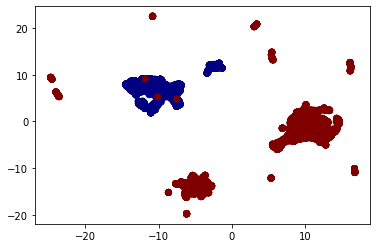

In [360]:
import matplotlib.pyplot as plt

plt.scatter(train_proj[:,0], train_proj[:,1], c = ts_train.y, cmap='jet')


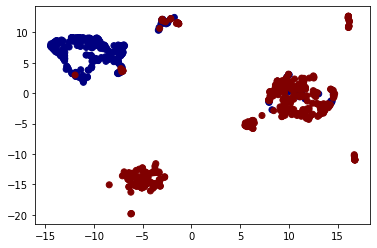

In [361]:
plt.scatter(test_proj[:,0], test_proj[:,1], c = ts_test.y, cmap='jet')

## Risk Minimization - SVM

In [362]:
from sklearn.svm import SVC

clf = SVC(gamma='auto', C=1)
# clf = SVC(kernel="linear", C=0.05)

clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))

print(metrics.balanced_accuracy_score(ts_test.y, test_pr))

0.9236673773987207


## Risk Minimization -  Neural Network model

In [363]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=400)
clf.fit(ts_train.features, ts_train.y)

train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))
print(metrics.balanced_accuracy_score(ts_test.y, test_pr))

0.9236673773987207


# Straight-forward Classifier


In [364]:

from sklearn.tree import DecisionTreeClassifier

# clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
# clf = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(ts_train.features, ts_train.y)


train_pr = clf.predict(ts_train.features)
test_pr = clf.predict(ts_test.features)

In [365]:
# print(metrics.classification_report(ts_test.y, test_pr, target_names=CLASS_LABELS))
print(metrics.balanced_accuracy_score(ts_test.y, test_pr))

0.8913036856533658


# Plugin - Linear Discriminant Analysis


In [366]:
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split


In [367]:
X_train = ts_train.features
Y_train = ts_train.y

x_test = ts_test.features
y_test = ts_test.y

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1)

In [368]:
lda = LinearDiscriminantAnalysis(solver="svd")
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.9272727272727272
0.9236673773987207


In [369]:
lda = LinearDiscriminantAnalysis(solver="svd", shrinkage=None, tol=0.1)
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.9272727272727272
0.9236673773987207


In [370]:
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage=None)
lda.fit(x_train, y_train)

y_pred = lda.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.9272727272727272
0.9236673773987207


In [371]:
def get_pred(test_neigh):
  c10 = 1
  c01 = 1
  p1 = np.mean(y_train)
  p0 = 1 - np.mean(y_train)
  Lambda = y_train[test_neigh].mean(axis=1)/(1-y_train[test_neigh].mean(axis=1))
  eta = (c10*p0)/(c01*p1)
  print(eta)

  y_pred = (Lambda>eta)*1
  return y_pred


In [372]:
n_neighbors = 5
neigh = NearestNeighbors(algorithm='auto', n_neighbors=n_neighbors, leaf_size=30, metric='minkowski')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.5956346927053418
0.9272727272727272
0.9236673773987207


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [373]:
n_neighbors = 5
neigh = NearestNeighbors(algorithm='brute', n_neighbors=n_neighbors, leaf_size=30, metric='minkowski')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.5956346927053418
0.9272727272727272
0.9236673773987207


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [374]:
n_neighbors = 5
neigh = NearestNeighbors(algorithm='auto', n_neighbors=n_neighbors, leaf_size=25, metric='minkowski')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.5956346927053418
0.9272727272727272
0.9236673773987207


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [375]:
n_neighbors = 3
neigh = NearestNeighbors(algorithm='auto', n_neighbors=n_neighbors, leaf_size=25, metric='manhattan')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.5956346927053418
0.9272727272727272
0.9236673773987207


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [376]:
n_neighbors = 3
neigh = NearestNeighbors(algorithm='brute', n_neighbors=n_neighbors, leaf_size=25, metric='manhattan')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


0.5956346927053418
0.9272727272727272
0.9236673773987207


In [377]:
n_neighbors = 2
neigh = NearestNeighbors(algorithm='auto', n_neighbors=n_neighbors, leaf_size=25, metric='cosine')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.5956346927053418
0.9212121212121213
0.9162046908315564


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [378]:
n_neighbors = 2
neigh = NearestNeighbors(algorithm='brute', n_neighbors=n_neighbors, leaf_size=25, metric='cosine')
neigh.fit(x_train)

test_neigh = neigh.kneighbors(x_test, n_neighbors, return_distance=False)
y_pred = get_pred(test_neigh)

print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred))

0.5956346927053418
0.9212121212121213
0.9162046908315564


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 1.0, 'rf - test')

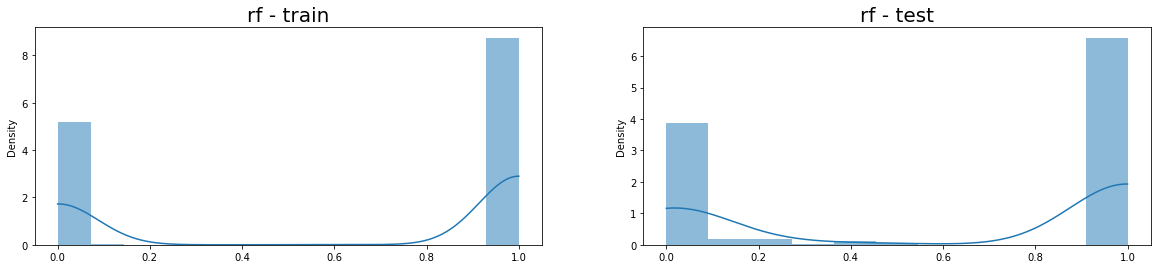

In [379]:
rf = RandomForestClassifier()    
# rf = SVC(probability=True, C=0.01)
rf.fit(x_train, y_train)

pred_probs_train = rf.predict_proba(x_train)[:,1]
pred_probs_test = rf.predict_proba(x_test)[:,1]
pred_probs_valid = rf.predict_proba(x_val)[:,1]

model_to_probs = {'train': pred_probs_train, 'test': pred_probs_test, 'valid': pred_probs_valid}

plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
sns.histplot(pred_probs_train, kde=True, stat="density", linewidth=0)
plt.title("rf - train", fontsize=20)

plt.subplot(1,2,2)
sns.histplot(pred_probs_test, kde=True, stat="density", linewidth=0)
plt.title("rf - test", fontsize=20)

In [380]:
# pred_probs

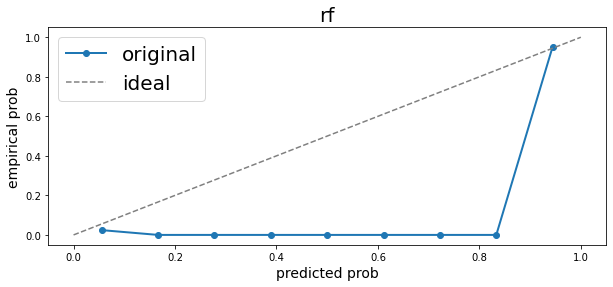

In [381]:
pred_probs = model_to_probs['test']
pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    vals = y_test[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]
    # print(vals)
    if len(vals) != 0:
        empirical_probs.append(np.mean(vals))
    else:
        empirical_probs.append(0)
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

plt.figure(figsize=(10,4))
plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
plt.title("rf", fontsize=20)
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)

plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.legend(['original', 'ideal'], fontsize=20)
plt.savefig('empirical.png', bbox_inches='tight')
plt.show()

Brier score of  0.07150307785396035


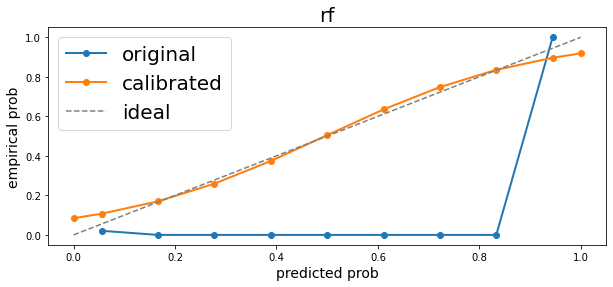

In [382]:
#train calibration model
lr_model = LogisticRegression()
lr_model.fit(model_to_probs['test'].reshape(-1,1), y_test)

pred_probs = model_to_probs['valid']
pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    vals = y_val[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]
    if len(vals) != 0:
        empirical_probs.append(np.mean(vals))
    else:
        empirical_probs.append(0)
    # empirical_probs.append(np.mean())
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

calibrated_probs = lr_model.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
print('Brier score of ', brier_score_loss(y_test, lr_model.predict_proba(model_to_probs['test'].reshape(-1,1))[:,1]))
# print('Balanced score of ', balanced_accuracy_score(y_test, lr_model.predict_proba(model_to_probs['test'].reshape(-1,1))[:,1]))

plt.figure(figsize=(10,4))
plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
plt.title("rf", fontsize=20)
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)

plt.plot([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='o')
plt.plot([0,1],[0,1],linestyle='--',color='gray')

plt.legend(['original', 'calibrated', 'ideal'], fontsize=20)
plt.savefig('calibration.png', bbox_inches='tight')
plt.show()

model_str_to_calibrator = lr_model

In [383]:
clf = RandomForestClassifier()    
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:,1]

In [400]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, balanced_accuracy_score, precision_score, roc_curve, auc, confusion_matrix

c01 = 0.98
c10 = 0.02



tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [401]:
print('Custo total:', fn*c01+fp*c10)

Custo total: 28.099999999999998


In [402]:
nu = c10*(1-np.mean(y_test))/(c01*np.mean(y_test))
t = nu/(1+nu)

In [403]:
t = nu/(1+nu)

In [404]:
y_pred_o = y_prob>t

In [405]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_o).ravel()

In [406]:
print('Custo total:', fn*c01+fp*c10)
# print('Falso negativo:', fn*c01)
print('Falso negativo:', fn)

Custo total: 28.580000000000002
Falso negativo: 26
